# Statistical Methods in Image Processing EE-048954
## Homework 1: Kernel Density Estimation and Normalizing Flows
### Due Date: <span style="color:red">May 08, 2022</span>

###  Submission Guidelines

* Submission only in **pairs** on the course website (Moodle).
* Working environment:
    * We encourage you to work in `Jupyter Notebook` online using <a href="https://colab.research.google.com/">Google Colab</a> as it does not require any installation.
* You should submit two **separated** files:
    * A `.ipynb` file, with the name: `ee048954_hw1_id1_id2.ipynb` which contains your code implementations.
    * A `.pdf` file, with the name: `ee048954_hw1_id1_id2.pdf` which is your report containing plots, answers, and discussions.
    * **No handwritten submissions** and no other file-types (`.docx`, `.html`, ...) will be accepted.

### Mounting your drive for saving/loading stuff

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

### Importing relevant libraries for Part I

In [1]:
## Standard libraries
import os
import math
import time
import numpy as np
import copy
import tqdm
## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
plt.style.use('ggplot')

## Part I: Kernel Density Estimation (30 points)

The multivariate kernel density estimate of a density $f(\mathbf{x})$ given a set of samples $\{\mathbf{x}_i\}$ is given by
$$\hat{f}(\mathbf{x}) = \frac{1}{N} \frac{1}{|H|} \sum_{i=1}^{N}  K(H^{-1} (\mathbf{x}_i-\mathbf{x})),
$$
where $H$ is a bandwidth matrix, $K(\cdot)$ is the kernel and $\{\mathbf{x}_i\}_{i=1}^N$ are $\textit{i.i.d.}$ samples drawn from $f(\mathbf{x})$.

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 1</span>**. Consider the following density functions:
  * Gaussian Mixture:
  $$f(\mathbf{x};\sigma,\{\mu_i\}) = \frac{1}{2\pi\sigma^2} \sum_{m=1}^{M} \frac{1}{M} \exp\left\{-\frac{1}{2\sigma^2}||\mathbf{x}-\mathbf{\mu}_i||^2\right\} ,$$
   with $M = 4$, $\sigma = \frac{1}{2}$, and $\{\mathbf{\mu}_m\} = \{(0,0)^T , (0,2)^T , (2,0)^T , (2,2)^T\}$.
  * Gaussian Mixture with $M = 4$, $\sigma = 1$, and $\{\mathbf{\mu}_m\} = \{(0,0)^T , (0,2)^T , (2,0)^T , (2,2)^T\} $.
  * Spiral with $\theta \sim \mathcal{U}[0,4\pi]$ and $r|\theta \sim \mathcal{N}(\frac{\theta}{2},0.25)$.
  
  For each of the three distributions above, implement a function that draws $N = 10000$ samples ${\mathbf{x}_i}$ from $f(\mathbf{x})$. Display the drawn samples for each distribution separately.

In [2]:
def mix_gauss_draw(M=4, sigma=1, mu=[np.array([1,0]),
                                     np.array([0,1]),
                                     np.array([-1,0]),
                                     np.array([0,-1])], N=10_000):
    
    Sigma = np.eye(len(mu[0])) * (sigma ** 2)
    X = np.zeros([N, len(mu[0])])
    G = np.zeros([N, 1])
    
    for i in range(N):
        m = np.random.choice(M,1)
        Mu = mu[int(m)]
        x = np.random.multivariate_normal(mean=Mu, cov=Sigma)
        X[i] = x
        G[i] = m
    return X, G

In [3]:
def spiral_draw(theta=4*np.pi, r_sigma=0.25, N=10_000):
    X = np.zeros([N, 2])
    for i in range(N):
        theta_i = np.random.uniform(0, theta)
        r = (theta_i / 2) + np.random.randn() * (0.25 ** 0.5)
        x = np.array([r * np.cos(theta_i), r * np.sin(theta_i)])
        X[i] = x
    return X
    

In [4]:
def plot_scatter(samples, title, group=None):
    if group is not None:
        plt.scatter(samples[:, 0], samples[:, 1], c=group)
    else:
        plt.scatter(samples[:, 0], samples[:, 1])
    plt.title(title)
    plt.show()    

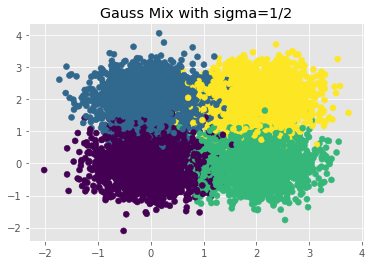

In [5]:
gauss_samples_half, group = mix_gauss_draw(M=4, sigma = 1/2, 
                                    mu = [np.array([0,0]), 
                                          np.array([0,2]), 
                                          np.array([2,0]), 
                                          np.array([2,2])])

plot_scatter(samples=gauss_samples_half, title="Gauss Mix with sigma=1/2", group=group)

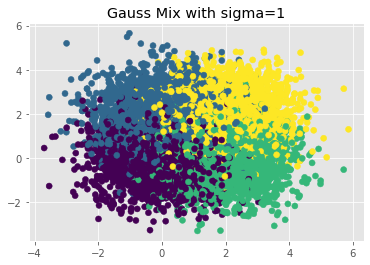

In [6]:
gauss_samples_one, group = mix_gauss_draw(M=4, sigma = 1, 
                                    mu = [np.array([0,0]), 
                                          np.array([0,2]), 
                                          np.array([2,0]), 
                                          np.array([2,2])])

plot_scatter(samples=gauss_samples_one, title="Gauss Mix with sigma=1", group=group)

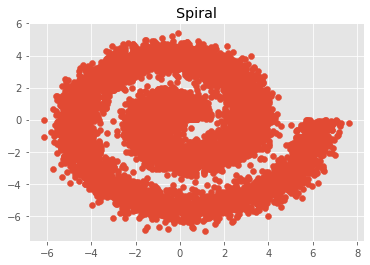

In [7]:
spiral_samples = spiral_draw()
plot_scatter(samples=spiral_samples, title="Spiral")

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 2</span>**. Implement a function that accepts samples $\{\mathbf{x}_i\}$ and a bandwidth matrix $ {H}$ and estimates $\hat{f}(\mathbf{x})$ using multivariate kernel density estimation. Use the two-dimension separable kernel $K( {u}) = k(u_1)k(u_2)$ where $k(u)= \frac{1}{\sqrt{2\pi}} \exp \{\frac{-u^2}{2}\}$.

In [8]:
def Kernel(y):
    """
    y - vector in R^2
    """
    y1 = y[0]
    y2 = y[1]
        
    k1 = (1/(2*np.pi)**0.5) * np.exp(-(y1**2) / 2)
    k2 = (1/(2*np.pi)**0.5) * np.exp(-(y2**2) / 2)
    
    return k1 * k2

In [9]:
def MKDE_single_point(point, samples, H):
    N = len(samples)
    det_H = np.linalg.det(H)
    inv_H = np.linalg.inv(H)
    C = (1/N) * (1/det_H)
    # run over all other samples
    kernel_sum = 0
    for sample in samples:
        difference = point - sample
        kernel_sum += Kernel(inv_H @ difference.T)
    
    return kernel_sum * C

In [10]:
def generate_meshgrid(x_start=-2, x_final=6, y_start=-2, y_final=6, delta=0.1):

    x = np.arange(x_start, x_final, step=delta)
    y = np.arange(y_start, y_final, step=delta)    
    rx, ry= np.meshgrid(x, y)
    
    return x, y, rx, ry

In [11]:
def MKDE(samples, H, mesh_coordinates, delta=0.1):
    """
    L - length of grid (-L/2, L/2)
    delta - resolution parameter
    H - bandwidth matrix
    
    """
    # create meshgrid
    x, y, rx, ry = generate_meshgrid(mesh_coordinates[0], mesh_coordinates[1], 
                                     mesh_coordinates[2], mesh_coordinates[3], delta=delta)   
    L1 = int((mesh_coordinates[1] - mesh_coordinates[0]) / delta)
    L2 = int((mesh_coordinates[3] - mesh_coordinates[2]) / delta)
    rz = np.zeros([L2,L1])
    
    # create z, calculate KDE
    with tqdm.tqdm(enumerate(x), unit=' x axis', total=len(x)) as X:
        for idx_x, x_i in X:
            for idx_y, y_i in enumerate(y):            
                prob = MKDE_single_point(point=(x_i, y_i), samples=samples, H=H)
                rz[idx_y][idx_x] = prob
    
    print("-I- Integral over density:", sum(sum(rz)) * delta ** 2)
    
    return rx, ry, rz    

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 3</span>**. For **each** distribution, compare between $f(\mathbf{x})$ and $\hat{f}(\mathbf{x})$ using the bandwidth matrices 
${H} = \begin{pmatrix}
	h & 0\\0 & h
	\end{pmatrix}$ with $h = 0.1,0.5,1$. and display the estimation.
	Discuss the trade-off of the choice of $h$.

Gauss, Sigma=1/2, h=0.1


100%|█████████████████████████████████████████████████████████████████████████████| 32/32 [02:08<00:00,  4.02s/ x axis]


-I- Integral over density: 1.0008897111975688
Gauss, Sigma=1, h=0.1


100%|█████████████████████████████████████████████████████████████████████████████| 32/32 [02:10<00:00,  4.07s/ x axis]


-I- Integral over density: 0.9964096745124676
Spiral, Sigma=1/2, h=0.1


100%|█████████████████████████████████████████████████████████████████████████████| 48/48 [04:50<00:00,  6.04s/ x axis]


-I- Integral over density: 0.9743027940403186
Gauss, Sigma=1/2, h=0.5


100%|█████████████████████████████████████████████████████████████████████████████| 32/32 [02:03<00:00,  3.85s/ x axis]


-I- Integral over density: 0.9999708387414112
Gauss, Sigma=1, h=0.5


100%|█████████████████████████████████████████████████████████████████████████████| 32/32 [02:05<00:00,  3.91s/ x axis]


-I- Integral over density: 0.9916126796914034
Spiral, Sigma=1/2, h=0.5


100%|█████████████████████████████████████████████████████████████████████████████| 48/48 [04:38<00:00,  5.80s/ x axis]


-I- Integral over density: 0.9662051017667297
Gauss, Sigma=1/2, h=1


100%|█████████████████████████████████████████████████████████████████████████████| 32/32 [02:08<00:00,  4.02s/ x axis]


-I- Integral over density: 0.992533889545752
Gauss, Sigma=1, h=1


100%|█████████████████████████████████████████████████████████████████████████████| 32/32 [02:09<00:00,  4.04s/ x axis]


-I- Integral over density: 0.965071777094471
Spiral, Sigma=1/2, h=1


100%|█████████████████████████████████████████████████████████████████████████████| 48/48 [04:35<00:00,  5.75s/ x axis]


-I- Integral over density: 0.9441714034386337


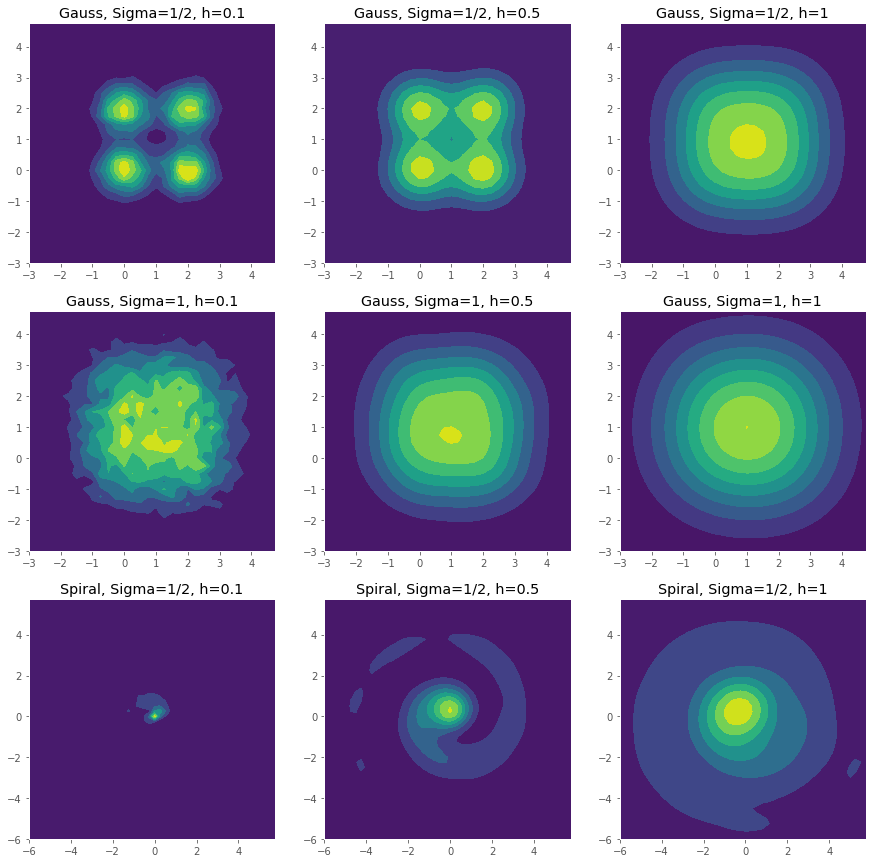

In [70]:
hs = [0.1, 0.5, 1]
Hs = [np.eye(2) * h for h in hs]

datasets = [gauss_samples_half, gauss_samples_one, spiral_samples]
titles = ["Gauss, Sigma=1/2, h=",
         "Gauss, Sigma=1, h=",
         "Spiral, Sigma=1/2, h="]

mesh_coordinates = [[-3,5,-3,5],
                    [-3,5,-3,5],
                    [-6,6,-6,6]]

delta = 0.25

fig, axes = plt.subplots(len(datasets), len(hs), figsize=(15,15), sharex=False, sharey=False)

for h_idx, H in enumerate(Hs):   
    for d_idx, data_samples in enumerate(datasets):   
        title = titles[d_idx]+str(hs[h_idx])
        print(title)
        rx, ry, rz = MKDE(samples=data_samples, H=H, mesh_coordinates=mesh_coordinates[d_idx], delta=delta)
        axes[d_idx, h_idx].contourf(rx, ry, rz)
        axes[d_idx, h_idx].set_title(title)

## Discussion
On the simplest level, the higher the h the wider the kernel, therefore for a higher h we get a smoother estimated density function. This is shown mostly on the gauss with sigma=1 in which for the higher h the density is estimated as a one gaussian. This is an example of the bias-variance trade off in which we can see that for the example above it's almost not matter the specific samples of the data, the results will always look like a single gaussian, as oppsed to the lower h in the gaussian with sigma=1/2 in which we can see that each sample can have higher siginicance and the fedeliaty to the dataset will be higher and the bias lower.

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 4</span>**. Which of the distributions was the easiest/hardest to estimate? Why?

$\color{#007FFF}{\textbf{Solution:}}$
Based on this last observation, the spiral draw is harder to estimate than the Gaussian draw. As can be seen that the tail of the spiral is hard to estimate correctly. We conjecture that this is due to the face that the kernel is symmetric and the dataset is not, this can cause some kind of "aliasing" in the density function.

### Importing additional relevant libraries for Part II

In [12]:
## Scikit-learn built-in dataset generators
from sklearn.datasets import make_moons, make_circles, make_blobs

## Progress bar
import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
from torch.distributions.multivariate_normal import MultivariateNormal

# Traning will be done on CPU for this homework. 
# For K=4, N=1500, epochs=1000 takes < 3 mins.
cpu_device = torch.device("cpu")
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = cpu_device
print("Using device", device)

Using device cpu


## Part II: Invertible Neural Networks (70 points) 

In this part, we will take a closer look at invertible neural networks, otherwise known as *Normalizing Flows*. The most popular, current application of normalizing flows is to model datasets of images. In this part, we will implement a type of flows called *Coupling Flows* for a simplified problem of sampling from toy 2D datasets, although similar concepts (with deeper models + tricks) can be used to model images.

### General Concept 
Recall that given a random vector $Z$ with a density $p_Z(\mathbf{z})$ (e.g. Gaussian) and an invertible function $f$, the density $p_X(\mathbf{x})$ of $X=f(Z)$ is given by:

$$
\log p_X(\mathbf{x}) = \log p_Z(f^{-1}(\mathbf{x})) + \log{} \left|\det \frac{df^{-1}(\mathbf{x})}{d\mathbf{x}}\right|
$$

### Toy Datasets 

The provided function `sample_2d_datasets` samples from 4 different toy datasets that we will use for this part to experiment with NFs. The supported options in this function are `{'Circles', 'Moons', 'GaussiansGrid', 'GaussiansRot'}`, where for the last distribution `'GaussiansRot'`, the function supports a varying number of gaussians using the parameter `num_gaussians`.

In [13]:
def sample_2d_datasets(dist_type, num_samples=1000, seed=0, num_gaussians=5):
    """
    function samples from simple pre-defined distributions in 2D.
    Inputs:
    - dist_type: str specifying the distribution to be chosen from:
      {'Circles', 'Moons', 'GaussiansGrid', 'GaussiansRot'}
    - num_samples: Number of samples to draw from dist_type (int).
    - seed: Random seed integer.
    - num_gaussians: Number of rotated gaussians if dist_type='GaussiansRot'. 
      (relevant only for dist_type='GaussiansRot', should be a keyword argument)
    Outputs:
    - data (np.array): array of num_samplesx2 samples from dist_type
    """
    np.random.seed(seed)
    if dist_type == 'Circles':
        data = make_circles(num_samples, noise=.1, factor=.8, random_state=seed, shuffle=True)[0]
    elif dist_type == 'Moons':
        data = make_moons(num_samples, noise=.1, random_state=seed, shuffle=True)[0]
    elif dist_type == 'GaussiansGrid':
        centers = np.array([[0,0],[0,2],[2,0],[2,2]])
        data = make_blobs(num_samples, centers=centers, cluster_std=.5, random_state=seed, shuffle=True)[0]
    elif dist_type == 'GaussiansRot':
        angles = np.linspace(0, 2 * np.pi, num_gaussians, endpoint=False)
        centers = np.stack([2.5 * np.array([np.cos(angle), np.sin(angle)]) for angle in angles])
        data = make_blobs(num_samples, centers=centers, cluster_std=np.sqrt(.1), random_state=seed, shuffle=True)[0]
    else:
        raise NotImplementedError
    return data

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 1</span>**. To get acquainted with this function, for each of the 4 distributions above, draw $N = 1000$ samples ${{x}_i}$. Display the drawn samples for each distribution in a separate plot.


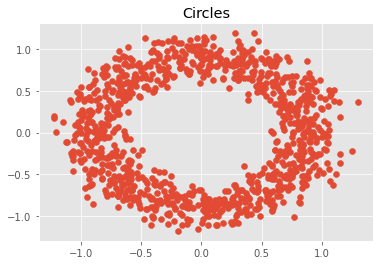

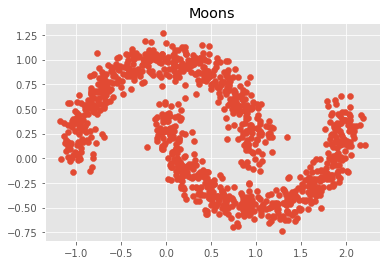

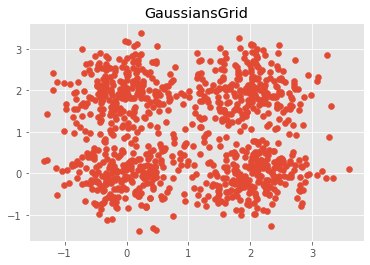

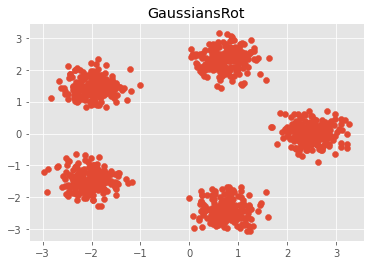

In [14]:
circles_samples = sample_2d_datasets(dist_type='Circles', num_samples=1000, seed=0)
moons_samples = sample_2d_datasets(dist_type='Moons', num_samples=1000, seed=0)
GaussGrid_samples = sample_2d_datasets(dist_type='GaussiansGrid', num_samples=1000, seed=0)
GaussRot_samples = sample_2d_datasets(dist_type='GaussiansRot', num_samples=1000, seed=0, num_gaussians=5)


plot_scatter(samples=circles_samples, title='Circles')
plot_scatter(samples=moons_samples, title='Moons')
plot_scatter(samples=GaussGrid_samples, title='GaussiansGrid')
plot_scatter(samples=GaussRot_samples, title='GaussiansRot')

For convience purposes, we wrap the function `sample_2d_datasets` with a `torch.utils.data.Dataset` class, and implement the methods `__len__` and `__getitem__` to sample batches afterward with dataloaders when we train our models.

In [15]:
class ToyDataset(Dataset):
    def __init__(self, dist_type, num_samples=1000, seed=0, num_gaussians=5):
        """
        Wrapper around the function "sample_2d_datasets" to allow iterating 
        batches using a datalaoder when training our normalizing flow model.
        """
        self.data = sample_2d_datasets(dist_type, num_samples, seed, num_gaussians)
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        return torch.from_numpy(self.data[index]).type(torch.FloatTensor)

### Coupling Layers 

Next, we look at possible transformations to apply inside the flow, focusing on the simplest and most efficient one. A recent popular flow layer, which works well in combination with deep neural networks, is the coupling layer introduced by [Dinh et al.](https://arxiv.org/abs/1605.08803). The input $\mathbf{x}$ is arbitrarily split into two parts, $\mathbf{x}_{1:j}$ and $\mathbf{x}_{j+1:d}$, of which the first remains unchanged by the flow. Yet, $\mathbf{x}_{1:j}$ is used to parameterize the transformation for the second part, $\mathbf{x}_{j+1:d}$. In this coupling layer, we apply an affine transformation by scaling the input by $\mathbf{s}$ and shifting it by $\mathbf{t}$. In other words, our transformation $\mathbf{y}=f(\mathbf{x})$ looks as follows:

$$\mathbf{y}_{1:j} = \mathbf{x}_{1:j}$$
$$\mathbf{y}_{j+1:d} = \mathbf{s}_{\theta_1}(\mathbf{x}_{1:j}) \odot \mathbf{x}_{j+1:d} + \mathbf{t}_{\theta_2}(\mathbf{x}_{1:j})$$

$\mathbf{y}$ is the output of the flow layer, the functions $\mathbf{s}$ and $\mathbf{t}$ are implemented as neural networks, and the sum and multiplication are performed element-wise. Here's a block diagram that visualize the coupling layer in the form of a computation graph:

<center width="100%"><img src="https://drive.google.com/uc?id=1R_omjSvfBN4xjkJgkmkwPX10jkjz_mmC" width="400px"></center>

For convience, since we train using the log-density, it is common practice to apply an exponential on the predicted scaling factor prior to multiplication with $\mathbf{x}_{j+1:d}$, as this simplifies the calculation of the log-determinant of the Jacobian that we will derive shortly. Hence, the implemented transformation in practice is usually:

$$\mathbf{y}_{1:j} = \mathbf{x}_{1:j}$$
$$\mathbf{y}_{j+1:d} = \exp(\mathbf{s}_{\theta_1}(\mathbf{x}_{1:j})) \odot \mathbf{x}_{j+1:d} + \mathbf{t}_{\theta_2}(\mathbf{x}_{1:j})$$

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 2</span>**. Write down the inverse of this layer $\mathbf{x}=f^{-1}(\mathbf{y})$ for some $\mathbf{x},\mathbf{y} \in \mathbb{R}^d$. Draw the inverse function $f^{-1}(\mathbf{y})$ as a computational graph that has $\mathbf{y}$ as input and $\mathbf{x}$ as output.

$\color{#007FFF}{\textbf{Solution:}}$

Split the input vector $x$ into $x_{1:j}$ and $x_{j+1:d}$. We have:

1. $$y_{1:j}=x_{1:j}$$
2. $$y_{j+1:d}=S_{\theta_{1}}\left(x_{1:j}\right)\cdot x_{j+1:d}+t_{\theta_{2}}\left(x_{1:j}\right)$$

Consequently, we can write that:
$$x_{1:j}=y_{1:j}$$
To evaluate $x_{j+1:d}$, notice that:
$$y_{j+1:d}=S_{\theta_{1}}\left(y_{1:j}\right)\cdot x_{j+1:d}+t_{\theta_{2}}\left(y_{1:j}\right)$$
And as a result:
$$x_{j+1:d}=\big(y_{j+1:d}-t_{\theta_{2}}\left(y_{1:j}\right)\big)\big/S_{\theta_{1}}\left(y_{1:j}\right)$$

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 3</span>**. Write down the Jacobian of this layer $\frac{d \mathbf{y}}{d \mathbf{x}}$. Do you recognize a special structure in this matrix?

$\color{#007FFF}{\textbf{Solution:}}$
1. For indices $a,b\in \{1\ldots j\}$: $\frac{d y_a}{d x_b} = \delta_{a,b} $ 
2. For indices $a,b\in \{j+1\ldots d\}$ : $ \frac{d y_a}{d x_b} = \delta_{a,b}\cdot\exp\{s(x_{b-d})\} $ 
3. For indices $a\in \{1\ldots j\}, b\in \{j+1\ldots d\}$: $ \frac{d y_a}{d x_b} = 0 $ 
4. For indices $a\in \{j+1\ldots d\}, b\in \{1\ldots j\}$: there is no simple form

Consequently, the Jacobian matrix takes the following shape:
$$\frac{d\mathbf{y}}{d\mathbf{x}} = \begin{pmatrix}
\mathbb{I}_j & \frac{d \mathbf{y_{j+1:d}}}{d \mathbf{x_{1:d}}} \\
0 & Diag\big(\exp\big\{s\left(x_{1:j}\right)\big\}\big)
\end{pmatrix} $$



<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 4</span>**. Write down the explicit expression for the *log*-determinant of the Jacobian matrix from the previous section.

$\color{#007FFF}{\textbf{Solution:}}$

Because the Jacobian matrix is of block structure, its determinant is the product of each block's determinant ($ac-bd$):
$$ \det\big(\frac{d\mathbf{y}}{d\mathbf{x}}\big) = \det\begin{pmatrix}
\mathbb{I}_j & \frac{d \mathbf{y_{j+1:d}}}{d \mathbf{x_{1:d}}} \\
0 & Diag\big(\exp\big\{s\left(x_{1:j}\right)\big\}\big)
\end{pmatrix} = \det\big(Diag\big(\exp\big\{s\left(x_{1:j}\right)\big\}\big)\big)=$$
$$=\prod_{i=1}^{j}\exp\big\{s\left(x_{1:j}\right)\big\}=\exp\big\{\sum_{i=1}^{j}s\left(x_{i}\right)\big\}$$
$$ \Rightarrow \log \det\big(\frac{d\mathbf{y}}{d\mathbf{x}}\big) = \sum_{i=1}^{j}s\left(x_{i}\right)$$

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 5</span>**. Write down the explicit expression for the *log*-determinant of the Jacobian matrix of the *inverse* function $\frac{d \mathbf{x}}{d \mathbf{y}}$.

$\color{#007FFF}{\textbf{Solution:}}$

The inverse transformation is very simillar except that $t$'s sign is negative, and we divide rather than multiply by the exponent:
$$\frac{d \mathbf{x}}{d \mathbf{y}} = \begin{pmatrix}
\mathbb{I}_j & \frac{d \mathbf{x_{j+1:d}}}{d \mathbf{y_{1:j}}} \\
0 & Diag\big(\exp\big\{-s\left(y_{1:j}\right\}\big)
\end{pmatrix} $$  
And since we saw this structure in the above section we can deduce:
$$ \Rightarrow \log \det\bigg(\frac{d \mathbf{x}}{d \mathbf{y}}\bigg) = -\sum_{i=1}^{j} s\big(y_{i}\big) $$

In our implementation, we will realize the splitting of variables as masking. The variables to be transformed, $\mathbf{x}_{j+1:d}$, are masked when passing $\mathbf{x}$ to the networks to predict the transformation parameters $\mathbf{s}_{\theta_1}(\mathbf{x}_{1:j})$ and $\mathbf{t}_{\theta_2}(\mathbf{x}_{1:j})$. Also, afterward when applying the transformation (don't forget to exponentiate the scaling!), we mask the parameters for $\mathbf{x}_{1:j}$ so that we have an identity operation for those variables.

For predicting the shifting and scaling parameters for our toy datasets we will be using neural networks with 3 Fully Connected layers with LeakyReLU activations in between. Additionally, for stabilization purposes, we multiply the scaling output $\mathbf{s}_{\theta_1}(\mathbf{x}_{1:j})$ prior to exponentiation with a learnable parameter per dimension `scale_factor` initialized to 0. Meaning, our scaling is initialized to 1 as $\exp(0) = 1$. This prevents sudden large scaling values that can destabilize training (especially in the beginning).

The functions $\mathbf{s}_{\theta_1}(\cdot)$, $\mathbf{t}_{\theta_2}(\cdot)$, and `scale_factor` are already implemented in the provided class `CouplingLayer` below for your convinience.

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 6</span>**. Implement missing `forward` and `inverse` methods in the class `CouplingLayer`:
  * The `forward` method should take in `x` and use the mask `self.mask` and the learnable functions `self.s_func`, `self.scale_factor` and `self.t_func` to predict the transformation parameters and compute `y`. This method should also return the parameter `log_det_jac` which is the log-determinant of the Jacobian.
  * The `inverse` method goes in the other direction. It takes in `y` and uses `self.mask`, `self.s_func`, `self.scale_factor` and `self.t_func` to compute `x`. This method should also return the parameter `inv_log_det_jac` which is the log-determinant of the Jacobian of $f^{-1}(\cdot)$.

In [16]:
def splitting_mask(size=2, mask=1):
    mask_tensor = torch.zeros(size)
    mask_tensor[:mask] = 1
    return mask_tensor    

In [17]:
class CouplingLayer(nn.Module):
    def __init__(self, mask, input_size=2):
        super(CouplingLayer, self).__init__()

        # mask for splitting (fixed not learnable)
        self.mask = nn.Parameter(mask, requires_grad=False)

        # scaling function and stabilizing scale_factor init. to 0
        self.s_func = nn.Sequential(nn.Linear(in_features=input_size, out_features=32), 
                                    nn.LeakyReLU(),
                                    nn.Linear(in_features=32, out_features=32), 
                                    nn.LeakyReLU(),
                                    nn.Linear(in_features=32, out_features=input_size))
        self.scale_factor = nn.Parameter(torch.Tensor(input_size).fill_(0.0))

        # shifting function
        self.t_func = nn.Sequential(nn.Linear(in_features=input_size, out_features=32), 
                                    nn.LeakyReLU(),
                                    nn.Linear(in_features=32, out_features=32), 
                                    nn.LeakyReLU(),
                                    nn.Linear(in_features=32, out_features=input_size))

    def forward(self, x):
        x1 = x * self.mask
        x2 = x * (1 - self.mask)
        
        s_theta_1 = self.s_func(x1) * self.scale_factor
        t_theta_2 = self.t_func(x1)
        
        y = x1 + (1-self.mask) * (x*torch.exp(s_theta_1) + t_theta_2)
        
        log_det_jac = ((1 - self.mask) * s_theta_1).sum(-1)
        
        return y, log_det_jac

    def inverse(self, y):        
        y1 = y * self.mask
        
        s_theta_1 = self.s_func(y1) * self.scale_factor
        t_theta_2 = self.t_func(y1)
        
        x = y1 + (1-self.mask)*(y - t_theta_2)*torch.exp(-s_theta_1)

        inv_log_det_jac = ((1 - self.mask) * -s_theta_1).sum(-1)

        
        return x, inv_log_det_jac

In [18]:
### Sanity Check Block ###
CL1 = CouplingLayer(mask=splitting_mask())
CL2 = CouplingLayer(mask=splitting_mask())
x = torch.tensor([-1,10])
x_11, log_jac_11 = CL1(x)
x_12, log_jac_12 = CL2(x_11)
x_22, log_jac_22 = CL1.inverse(x_12)
x_21, log_jac_21 = CL2.inverse(x_22)
assert (x == x_21).all()

### Coupling Flows

As you might have guessed by now, a coupling layer is powerful yet still limited in its ability to significantly alter the input. This is because it only operates on a chunk of it with element-wise manipulations due to the invertability constraint. We can go on with making our function $f$ more complex. How can we implement more complex invertible functions? The answer is: invertible function composition. We can stack multiple invertible functions $f_1,\dots,f_K$ (e.g. Coupling Layers) after each other, as all together, they still represent a single, invertible function. Specifically, if $\mathbf{y} = f_1(\mathbf{z})$ and $\mathbf{x} = f_2(\mathbf{y})$ are invertible functions, then $\mathbf{x} = f_2 \circ f_1 (\mathbf{z})$ is an invertible function and its inverse is given by $f_1^{-1} \circ f_2^{-1}$. More importantly, the calculation of the log-determinant of the Jacobian in this case is simple using the chain rule.

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 7</span>**. Assuming $\mathbf{y} = f_1(\mathbf{z})$ and $\mathbf{x} = f_2(\mathbf{y})$ are coupling layers, calculate the log-determinant of the Jacobian $\frac{d \mathbf{x}}{d \mathbf{z}}$. How is it related to the log-determinant of the Jacobians $\frac{d \mathbf{y}}{d \mathbf{z}}$ and $\frac{d \mathbf{x}}{d \mathbf{y}}$?

$\color{#007FFF}{\textbf{Solution:}}$

By using the chain rule, we can write:

$$ \frac{dx}{dz} = \frac{dx}{dy} \frac{dy}{dz} = \begin{pmatrix}
\mathbb{I}_j & \frac{d \mathbf{x_{j+1:d}}}{d \mathbf{y_{1:j}}} \\
0 & Diag\big(\exp\big\{-s_2\left(y_{1:j}\right)\big\}\big)
\end{pmatrix} \cdot \begin{pmatrix}
\mathbb{I}_j & \frac{d \mathbf{y_{j+1:d}}}{d \mathbf{z_{1:j}}} \\
0 & Diag\big(\exp\big\{-s_1\left(z_{1:j}\right)\big\}\big)
\end{pmatrix} =  $$

$$=\begin{pmatrix}
\mathbb{I}_j & \frac{d \mathbf{y_{j+1:d}}}{d \mathbf{z_{1:j}}} + \frac{d \mathbf{x_{j+1:d}}}{d \mathbf{y_{1:j}}}\cdot Diag\big(\exp\big\{-s_{1}\left(z_{1:j}\right)\big\}\big) \\
0 & Diag\big(\exp\big\{-s_2\left(y_{1:j}\right)\big\}\big)\cdot Diag\big(\exp\big\{-s_1\left(z_{1:j}\right)\big\}\big)
\end{pmatrix}$$

Note that the top-right element can be dismissed as it vanishes when calculating the Jacobian.

Coupling layers generalize to any masking technique we could think of. However, the most common approach is to split the input $\mathbf{x}$ in half using the mask. For our toy 2D datasets comprised of samples $\mathbf{x} = (p_x ,p_y) \in \mathbb{R}^{d=2}$, this means that either $\left\{\mathbf{x}_{1:j}=p_x, \mathbf{x}_{j+1:d}=p_y\right\}$, or $\left\{\mathbf{x}_{1:j}=p_y, \mathbf{x}_{j+1:d}=p_x\right\}$. These correspond to masks $\left[1,0\right]^T$ and $\left[0,1\right]^T$ respectively. 
Note that when we apply multiple coupling layers, we invert the masking every other layer so that each variable is transformed a similar amount of times.

#### Intuition in 1D

Intuitively, using multiple, learnable invertible functions, a normalizing flow attempts to transform $p_z(z)$ slowly into a more complex distribution which should finally be $p_x(x)$. We visualize the idea below
(figure credit - [Lilian Weng](https://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html)):

<center width="100%"><img src="https://lilianweng.github.io/posts/2018-10-13-flow-models/normalizing-flow.png" width="700px"></center>

Starting from $z_0$, which follows the prior Gaussian distribution, we sequentially apply the invertible functions $f_1,f_2,...,f_K$, until $z_K$ represents $x$.

#### Implementation

Using the `CouplingLayer` class from above, here we will implement a class named `CouplingFlow` that is comprised of stacked coupling layers. This class will have the following attributes:
* `num_layers` - a scalar passed at initialization that will determine the number of coupling layers to stack, refered to later as $K$.
* `self.layers` - a Module list comprised of $K$ stacked coupling layers each with its own mask. Note that the masks are fixed and non-learnable therefore we set their `requires_grad` property to `False` inside `CouplingLayer`.
* `self.prior` - This is the prior/base distribution. Here we will use a standard Gaussian distribution with a unit variance per dimension implemented using the `torch.distributions` module.

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 8</span>**. Implement the following 3 methods of this class:
* `log_probability` - method that takes in a batch of samples `x` and returns `log_prob` which is their log-probability $\log p(\mathbf{x})$. For convinience we will assume the overall function $f=f_K\circ f_{K-1} \dots \circ f_1$ satisfies $\mathbf{x} = f(\mathbf{z})$. Hence, to calculate the log-probability you should employ the inverse functions $f_i^{-1}$ starting from the last layer $f_K^{-1}$ (assuming $K$ layers).
* `sample_x` - method that takes in a parameter `num_samples` and returns samples `x` from $p(\mathbf{x})$ alongside their log-probability values `log_prob`. 
* `sample_x_each_step` - method takes in a parameter `num_samples` and returns a list of samples `samples` after each intermediate coupling layer in `self.layers`. The first element of this list is samples from the prior distribution $p(\mathbf{z})$ and the last element is samples from $p(\mathbf{x})$.

In [19]:
class CouplingFlow(nn.Module):
    def __init__(self, num_layers):
        super(CouplingFlow, self).__init__()
  
        # concatenate coupling layers with alternating masks
        masks = F.one_hot(torch.tensor([i % 2 for i in range(num_layers)])).float().to(device)
        self.layers = nn.ModuleList([CouplingLayer(mask).to(device) for mask in masks])

        # define prior distribution to be z~N(0,I)
        self.prior = MultivariateNormal(torch.zeros(2).to(device),torch.eye(2).to(device))

    def log_probability(self, x):
        log_prob = torch.zeros(x.shape[0])
        for layer in reversed(self.layers):
            x, inv_log_det_jac = layer.inverse(x)
            log_prob += inv_log_det_jac
            
        log_prob += self.prior.log_prob(x)

        return log_prob

    def sample_x(self, num_samples):
        x = self.prior.sample((num_samples,))
        log_prob = self.prior.log_prob(x)

        for layer in self.layers:
            x, log_det_jac = layer(x)
            log_prob -= log_det_jac
        ### Sanity check between the log prob ans this function result ###
        assert abs(log_prob - self.log_probability(x)) < 1e-6
        return x, log_prob

    def sample_x_each_step(self, num_samples):
        samples = []

        x = self.prior.sample((num_samples,))
        samples.append(to_np(x))

        for layer in self.layers:
            x, _ = layer(x)
            samples.append(to_np(x))

        return samples

### Training Coupling Flows

Now that we have finished implementing the flow model, we can start training it. Provided below is an already implemented function `train` to train your `CouplingFlow` models. The function recieves 4 arguments:
* `model` - an instance of the class `CouplingFlow`.
* `data` - an instance of the class `ToyDataset`.
* `epochs` - number of epochs to train the model (int). 
* `batch_size` - the batch size to use in training (int).

In [20]:
# detach tensor and transfer to numpy
def to_np(x):
    return x.detach().numpy()

# Simple training function
def train(model, data, epochs = 100, batch_size = 64):

    # move model into the device
    model = model.to(device)

    # split into training and validation, and create the loaders
    lengths = [int(len(data)*0.9), len(data) - int(len(data)*0.9)]
    train_set, valid_set = random_split(data, lengths)
    train_loader = DataLoader(train_set, batch_size=batch_size)
    valid_loader = DataLoader(valid_set, batch_size=batch_size)

    # define the optimizer and scheduler
    optimizer = Adam(model.parameters(), lr=1e-3)

    # train the model
    train_losses, valid_losses, min_valid_loss = [], [], np.Inf
    with tqdm.tqdm(range(epochs), unit=' Epoch') as tepoch:
        for epoch in tepoch:

            # training loop
            epoch_loss = 0
            model.train(True)
            for batch_index, training_sample in enumerate(train_loader):
                log_prob = model.log_probability(training_sample)
                loss = - log_prob.mean(0)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss += loss

            epoch_loss /= len(train_loader)
            train_losses.append(np.copy(to_np(epoch_loss)))

            # validation loop
            epoch_loss_valid = 0
            model.train(False)
            for batch_index, valid_sample in enumerate(valid_loader):
                log_prob = model.log_probability(valid_sample)
                loss_valid = - log_prob.mean(0)
                epoch_loss_valid += loss_valid

            epoch_loss_valid /= len(valid_loader)
            valid_losses.append(np.copy(to_np(epoch_loss_valid)))

            # save best model based off validation loss
            if epoch_loss_valid < min_valid_loss:
                model_best = copy.deepcopy(model)
                min_valid_loss = epoch_loss_valid
                epoch_min = epoch

            # report progress with tqdm pbar
            tepoch.set_postfix(train_loss=to_np(epoch_loss), valid_loss=to_np(epoch_loss_valid))

    # report best model on val.
    print('\n Best Model achieved {:.4f} validation loss at epoch {} \n'.format(min_valid_loss, epoch_min))

    # if the number of samples is too low take the final weights regardless of 
    # valdiation loss due to weak statistics (overfitting avoided by early stopping)
    if lengths[1] < 500:
        model_best = model

    return model_best, train_losses, valid_losses

Here is an example snippet for using this function to train a flow model with $K=4$ layers on a dataset of $N=1500$ samples $\mathbf{x}_i$ from the `'Moons'` distribution for 1000 epochs:

In [21]:
# seeds to ensure reproducibility
torch.manual_seed(8)
np.random.seed(0)

# dataset
num_samples = 1500
data = ToyDataset('Moons', num_samples=num_samples)

# learning hyper-parameters
K = 4
nepochs = 10

# instantiate model and optimize the parameters
Flow_model = CouplingFlow(num_layers=K)
moon_model, train_loss, valid_loss = train(Flow_model, data, epochs=nepochs)


100%|███████████████████████████████████| 10/10 [00:01<00:00,  5.67 Epoch/s, train_loss=1.6477581, valid_loss=1.611797]


 Best Model achieved 1.6118 validation loss at epoch 9 



<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 9</span>**. For each of the 4 provided distributions (use the default value of `num_gaussians=5` for `'GaussiansRot'`), use a similar snippet to repeat the following:
  * Create a `ToyDataset` instance with $N=1500$ samples from the distribution.
  * Learn a `CouplingFlow` model with $K=4$ layers, by training for 500 epochs. For the `'Moons'` dataset train for 1000 epochs.
  * Plot the estimated density $p(\mathbf{x})$ in $\mathbb{R}^2$. To achieve this, use the method `log_probability` to calculate the log-probability $\log p(\mathbf{x})$ at a pre-determined grid of points $\mathbf{x} \in \left[x_{\min},x_{\max}\right]\times\left[y_{\min},y_{\max}\right]\subset\mathbb{R}^2$ (e.g. using `np.meshgrid`). Sample each coordinate with at least 100 points (i.e. a grid of $100 \times 100$ positions in 2D). Plot the resulting 2D distribution $p(\mathbf{x})=\exp (\log p(\mathbf{x}))$ as an image where the value in each pixel is $p(\mathbf{x})$.
  * Plot samples from intermediate flow layers, including the prior $p(\mathbf{z})$ and the modelled $p(\mathbf{x})$. To achieve this, use the method `sample_x_each_layer` with $N=1000$ samples. Plot the resulting samples from each layer in the **same** axis limits to visualize the transformation of each coupling layer separately. You can use `plt.subplot(..., sharex=True, sharey=True)` to achieve link the axis of all subplots.


Implementation tips:
* Use the same seeds as the example snippet for reproducibility. This will also ensure a non-diverging erroneous behavior with other seeds.
* To make sure the model is not overfitting you can look at the training and the valdiation loss outputs of the provided function `train`. Do not include these in your report, use them just for sanity check.
* Estimate the log-probability in a reasonable vicinity of the training domain. For far away coordinates from the training data, the estimation could be poor locally and might bias the dynamic range of your plot.
* To avoid code duplication, you are encouraged to implement two plotting functions: one for plotting the density, and one for plotting the transformations across layers.

## $\color{#007FFF}{\textbf{Data sets:}}$

In [22]:
# create datasets
num_samples = 1500
data_moon = ToyDataset('Moons', num_samples=num_samples)
data_circles = ToyDataset('Circles', num_samples=num_samples)
data_gauss_grid = ToyDataset('GaussiansGrid', num_samples=num_samples)
data_gauss_rot = ToyDataset('GaussiansRot', num_samples=num_samples)

## $\color{#007FFF}{\textbf{Learn & Plot functions:}}$

In [23]:
def learn_coupling_flow(data_set, K=4, epochs=500):
    torch.manual_seed(8)
    np.random.seed(0)

    # instantiate model and optimize the parameters
    Flow_model = CouplingFlow(num_layers=K)
    moon_model, train_loss, valid_loss = train(Flow_model, data_set, epochs=epochs)
    
    return moon_model, train_loss, valid_loss

In [24]:
def plot_layers_output(model, real_data, num_samples=1000, prefix="", figsize=(15,10)):
    layer_samples = model.sample_x_each_step(num_samples)
    
    width = int((len(layer_samples))/2)+1
    
    fig, ax = plt.subplots(2, width, sharex=True, sharey=True, figsize=figsize)
    
    for idx, l_samples in enumerate(layer_samples):
        ax[int(idx/width), idx % width].scatter(l_samples[:,0], l_samples[:,1])
        if idx == 0:
            title = "Z0"
        else:
            title = prefix+" L"+str(idx)
        ax[int(idx/width), idx % width].set_title(title)
    
    ax[1, width-1].scatter(real_data[:,0], real_data[:,1])
    ax[1, width-1].set_title('Real Data')
    plt.show()
    

In [25]:
def plot_training_metrices(train_loss, valid_loss, prefix = "", figsize=(15,5)):
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    ax[0].plot(train_loss)
    ax[0].set_title(prefix+" train loss vs #epoch")
    ax[1].plot(valid_loss)
    ax[1].set_title(prefix+" validation loss vs #epoch")
    plt.show()

In [26]:
def plot_model_prob_density(gen_model, title="gen model probabillity", x_start=-2, 
                            x_final=2, y_start=-2, y_final=2, delta=0.04):
    x,y,rx,ry = generate_meshgrid(x_start=x_start, x_final=x_final, y_start=y_start, y_final=y_final, delta=delta)
    z = np.zeros(rx.shape)
    
    with tqdm.tqdm(enumerate(x), unit=' x axis', total=len(x)) as X:
        for idx_x, x_i in X:
            for idx_y, y_i in enumerate(y):
                point = torch.tensor([[x_i, y_i]])
                point = point.float()
                z[idx_y, idx_x] = torch.exp(gen_model.log_probability(point))
                #print(point, z[idx_y, idx_x])
    plt.contourf(rx, ry, z)
    plt.title(title+", Delta="+str(delta))
    plt.show()
    print("-I- Integral over density:", sum(sum(z)) * delta ** 2)
    return rx, ry, z

# $\color{#007FFF}{\textbf{Circles Solution:}}$

In [27]:
prefix = "Circles data, K=4 model,"
gen_model, train_loss, valid_loss = learn_coupling_flow(data_set=data_circles, K=4, epochs=500)

100%|█████████████████████████████████| 500/500 [01:25<00:00,  5.84 Epoch/s, train_loss=1.192069, valid_loss=1.3200402]


 Best Model achieved 1.2591 validation loss at epoch 405 



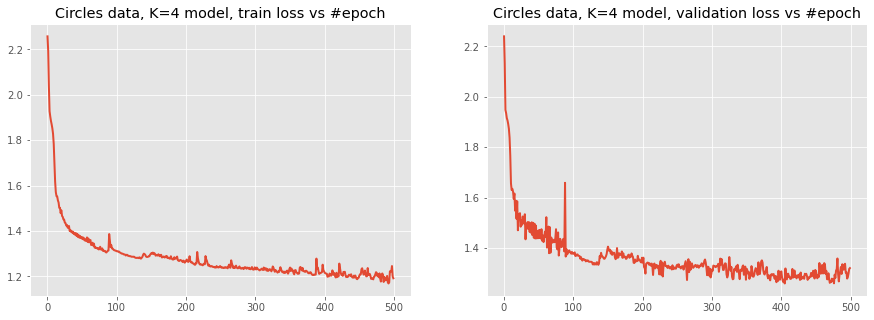

In [28]:
plot_training_metrices(train_loss=train_loss, valid_loss=valid_loss, prefix=prefix)

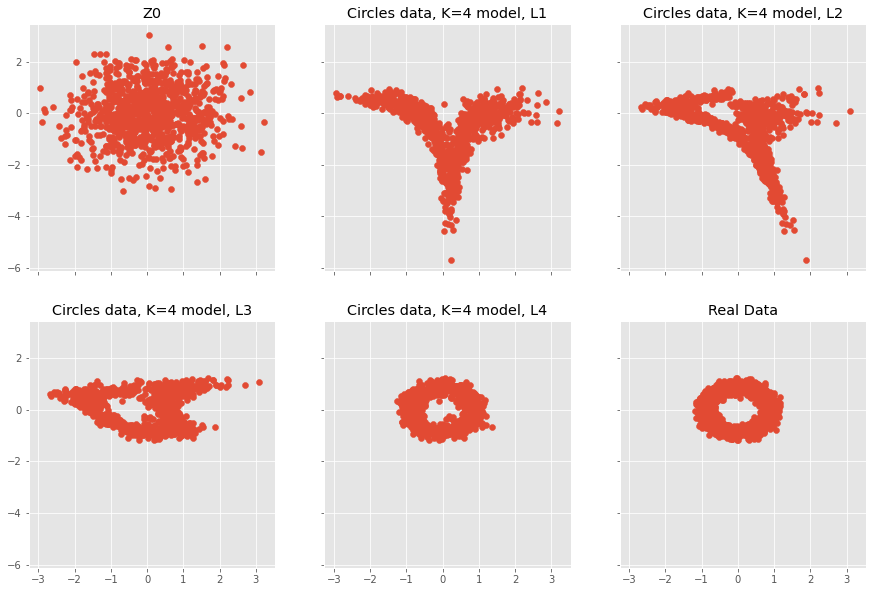

In [29]:
plot_layers_output(model=gen_model, real_data=data_circles.data, num_samples=1000, prefix=prefix)

100%|███████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.95 x axis/s]


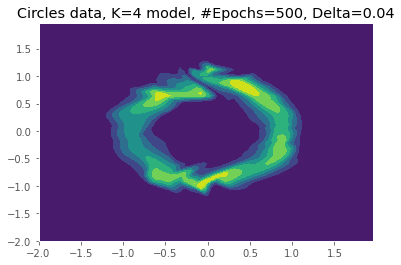

-I- Integral over density: 0.9994328543551685


In [30]:
rx, ry, z = plot_model_prob_density(gen_model=gen_model, title="Circles data, K=4 model, #Epochs=500")

# $\color{#007FFF}{\textbf{Moons Solution:}}$


In [31]:
prefix = "Moons data, K=4 model,"
gen_model, train_loss, valid_loss = learn_coupling_flow(data_set=data_moon, K=4, epochs=1000)

100%|██████████████████████████████| 1000/1000 [02:53<00:00,  5.77 Epoch/s, train_loss=1.0528344, valid_loss=1.2951512]


 Best Model achieved 1.2400 validation loss at epoch 374 



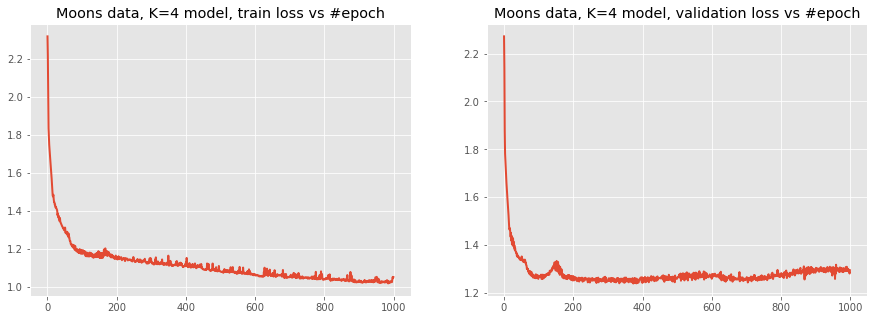

In [32]:
plot_training_metrices(train_loss=train_loss, valid_loss=valid_loss, prefix=prefix)

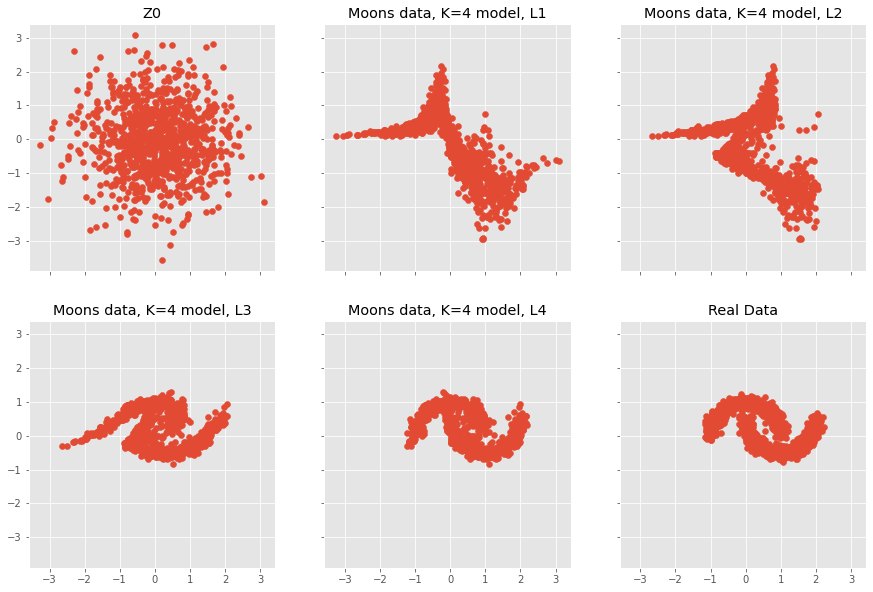

In [33]:
plot_layers_output(model=gen_model, real_data=data_moon.data, num_samples=1000, prefix=prefix)

100%|███████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.29 x axis/s]


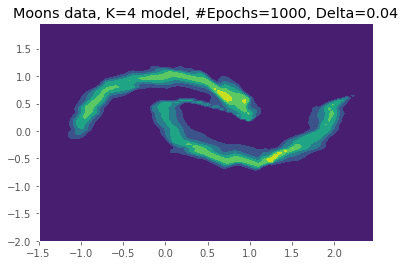

-I- Integral over density: 0.9999760828303877


In [34]:
rx, ry, z = plot_model_prob_density(gen_model=gen_model, title="Moons data, K=4 model, #Epochs=1000", x_start=-1.5, x_final=2.5)

# $\color{#007FFF}{\textbf{Gaussian Grid Solution:}}$


In [35]:
prefix = "Gauss Grid data, K=4 model,"
gen_model, train_loss, valid_loss = learn_coupling_flow(data_set=data_gauss_grid, K=4, epochs=500)

100%|█████████████████████████████████| 500/500 [01:18<00:00,  6.35 Epoch/s, train_loss=2.689291, valid_loss=2.7291186]


 Best Model achieved 2.7065 validation loss at epoch 444 



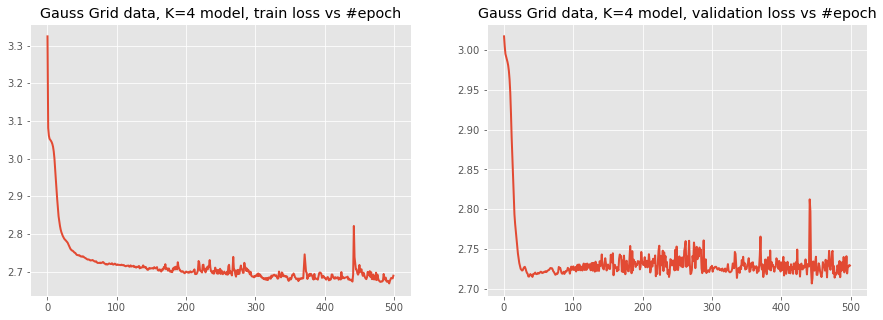

In [36]:
plot_training_metrices(train_loss=train_loss, valid_loss=valid_loss, prefix=prefix)

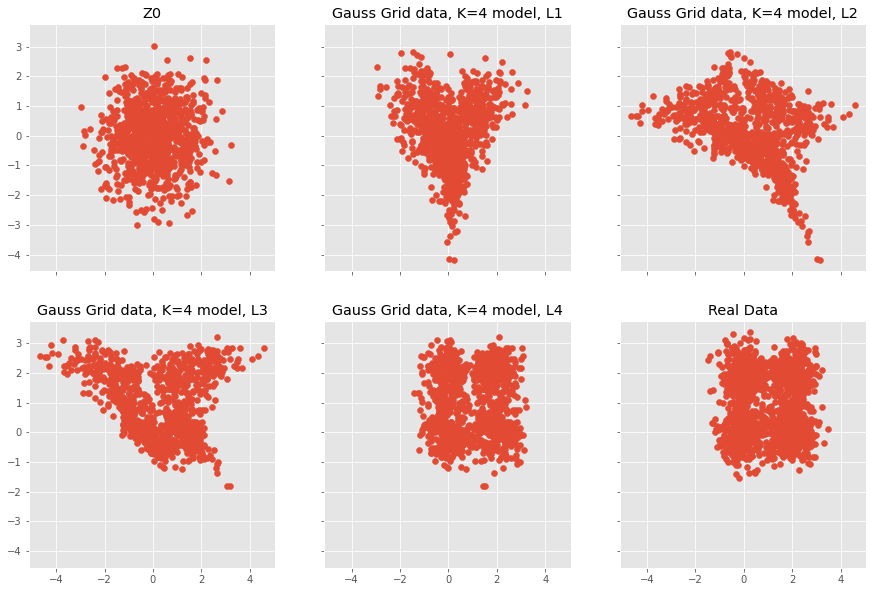

In [37]:
plot_layers_output(model=gen_model, real_data=data_gauss_grid.data, num_samples=1000, prefix=prefix)

100%|███████████████████████████████████████████████████████████████████████████| 150/150 [00:35<00:00,  4.22 x axis/s]


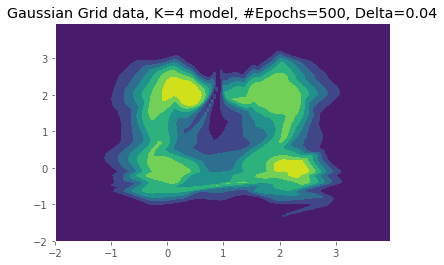

-I- Integral over density: 0.9998618441843763


In [38]:
rx, ry, z = plot_model_prob_density(gen_model=gen_model, title="Gaussian Grid data, K=4 model, #Epochs=500", 
                                    x_start=-2, x_final=4, y_start=-2, y_final=4)

# $\color{#007FFF}{\textbf{Gaussian Rot Solution:}}$


In [39]:
prefix = "Gauss Rot data, K=4 model,"
gen_model, train_loss, valid_loss = learn_coupling_flow(data_set=data_gauss_rot, K=4, epochs=500)

100%|████████████████████████████████| 500/500 [01:24<00:00,  5.89 Epoch/s, train_loss=2.2891233, valid_loss=2.7285254]


 Best Model achieved 2.3523 validation loss at epoch 271 



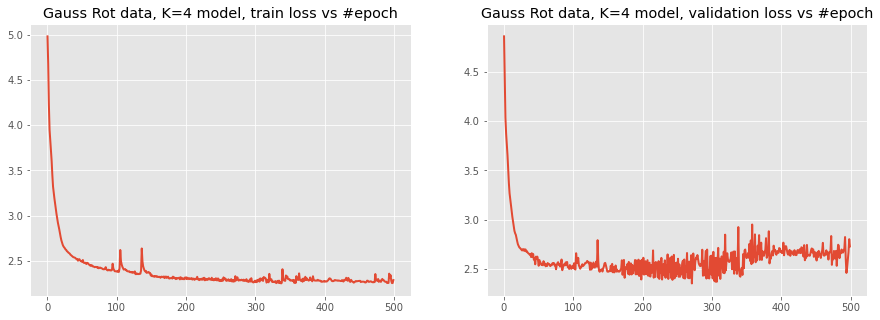

In [40]:
plot_training_metrices(train_loss=train_loss, valid_loss=valid_loss, prefix=prefix)

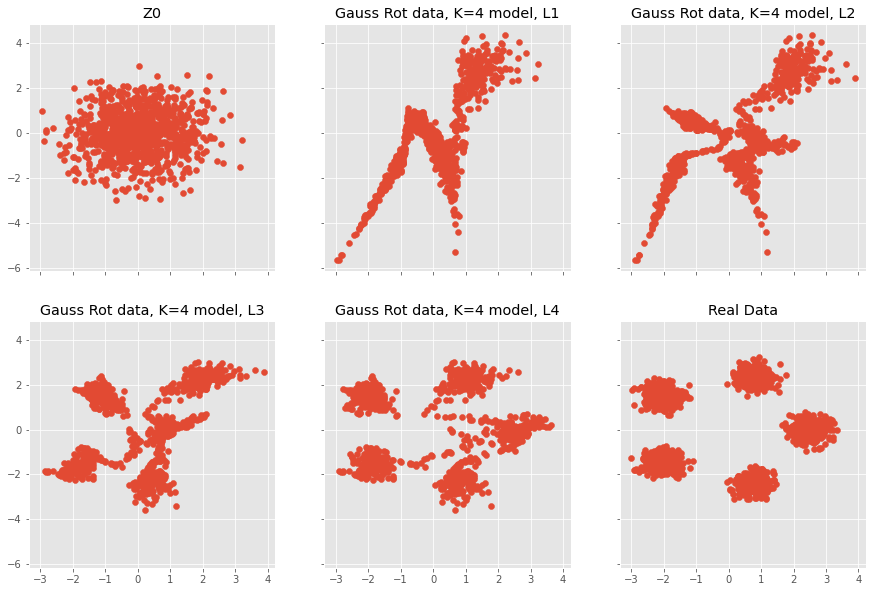

In [41]:
plot_layers_output(model=gen_model, real_data=data_gauss_rot.data, num_samples=1000, prefix=prefix)

100%|███████████████████████████████████████████████████████████████████████████| 200/200 [00:58<00:00,  3.40 x axis/s]


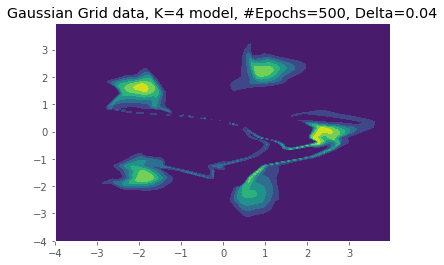

-I- Integral over density: 0.9995949536624734


In [42]:
rx, ry, z = plot_model_prob_density(gen_model=gen_model, title="Gaussian Grid data, K=4 model, #Epochs=500", 
                                    x_start=-4, x_final=4, y_start=-4, y_final=4)

### Analyzing Coupling Layers

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 10</span>**. Train two flow models with a varying number of coupling layers $K=\left\{2, 4\right\}$ for 250 epochs, using $N=1500$ samples from the `'GaussiansRot'` dataset with `num_gaussians=5`. Compare the resulting estimated density $p(\mathbf{x})$ (using a grid of $100 \times 100$ points) and the intermediate distributions of $N=1000$ samples throughout the coupling layers of the model. Which model fits $p(\mathbf{x})$ better? What do you conclude regarding the effect of model depth? explain the result in your report and attach the resulting plots.   

# $\color{#007FFF}{\textbf{Solution:}}$

100%|██████████████████████████████████| 250/250 [00:39<00:00,  6.27 Epoch/s, train_loss=2.278333, valid_loss=2.564162]



 Best Model achieved 2.3887 validation loss at epoch 243 



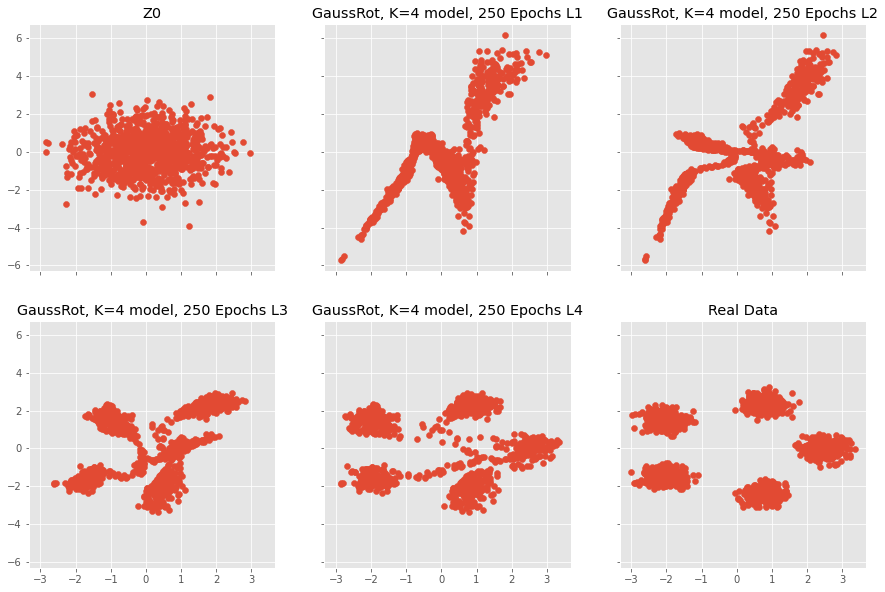

100%|███████████████████████████████████████████████████████████████████████████| 200/200 [01:09<00:00,  2.86 x axis/s]


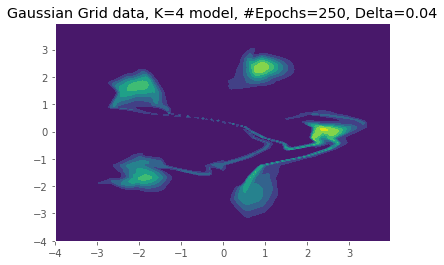

-I- Integral over density: 0.999971986515885


In [43]:
gen_model_K4, train_loss_K4, valid_loss_K4 = learn_coupling_flow(data_set=data_gauss_rot, K=4, epochs=250)
plot_layers_output(model=gen_model_K4, real_data=data_gauss_rot.data, num_samples=1000, 
                   prefix="GaussRot, K=4 model, 250 Epochs")
rx, ry, z = plot_model_prob_density(gen_model=gen_model_K4, title="Gaussian Grid data, K=4 model, #Epochs=250", 
                                    x_start=-4, x_final=4, y_start=-4, y_final=4)

100%|████████████████████████████████| 250/250 [00:30<00:00,  8.14 Epoch/s, train_loss=2.6173975, valid_loss=2.6030538]



 Best Model achieved 2.5809 validation loss at epoch 244 



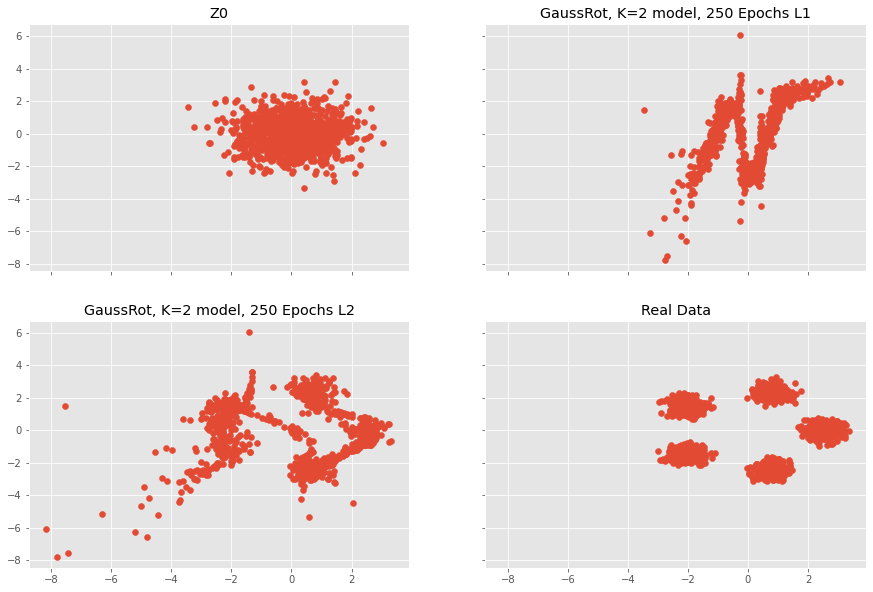

100%|███████████████████████████████████████████████████████████████████████████| 200/200 [00:38<00:00,  5.14 x axis/s]


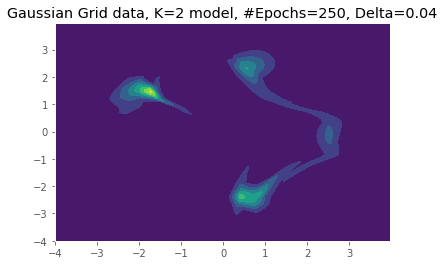

-I- Integral over density: 0.9761828022708564


In [44]:
gen_model_K2, train_loss_K2, valid_loss_K2 = learn_coupling_flow(data_set=data_gauss_rot, K=2, epochs=250)
plot_layers_output(model=gen_model_K2, real_data=data_gauss_rot.data, num_samples=1000, 
                   prefix="GaussRot, K=2 model, 250 Epochs")
rx, ry, z = plot_model_prob_density(gen_model=gen_model_K2, title="Gaussian Grid data, K=2 model, #Epochs=250", 
                                    x_start=-4, x_final=4, y_start=-4, y_final=4)

## $\color{#007FFF}{\textbf{Discussion:}}$
We can see that the number of layers is critical. We conjecture that is critical because the Gaussian Rot data need to be describe by at least 3 parameters - outside radius, inner variance, and coordinates of the circles. Therefore requires high expresivity of the network and therefor require more layers.
We verified this conjecture by trying the same expirement on the Circles data which require basiclly one parameter - radius. The results between the circles data with K=2 and K=4 was more simmilar that the difference between the Gauss Rot with K=2, 4.


<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 11</span>**. Train two flow models with $K=4$ layers for 400 epochs, using a varying number of $N=\left\{1500, 3000\right\}$ samples from the `'GaussiansRot'` dataset with `num_gaussians=5`. Compare the resulting estimated density $p(\mathbf{x})$ (using a grid of $100 \times 100$ points) and the intermediate distributions of $N=1000$ samples throughout the coupling layers of the model. Which model fits $p(\mathbf{x})$ better? What do you conclude regarding the effect of training set size? explain the result in your report and attach the resulting plots.

## $\color{#007FFF}{\textbf{Solution:}}$

In [45]:
data_gauss_rot_1500 = ToyDataset('GaussiansRot', num_samples=1500)
data_gauss_rot_3000 = ToyDataset('GaussiansRot', num_samples=3000)

In [46]:
gen_model_15, train_loss_15, valid_loss_15 = learn_coupling_flow(data_set=data_gauss_rot_1500, K=4, epochs=400)

100%|█████████████████████████████████| 400/400 [01:03<00:00,  6.25 Epoch/s, train_loss=2.2791052, valid_loss=2.672677]


 Best Model achieved 2.3523 validation loss at epoch 271 



In [47]:
gen_model_30, train_loss_30, valid_loss_30 = learn_coupling_flow(data_set=data_gauss_rot_3000, K=4, epochs=400)

100%|████████████████████████████████| 400/400 [02:14<00:00,  2.97 Epoch/s, train_loss=2.2936966, valid_loss=2.5755007]


 Best Model achieved 2.5283 validation loss at epoch 305 



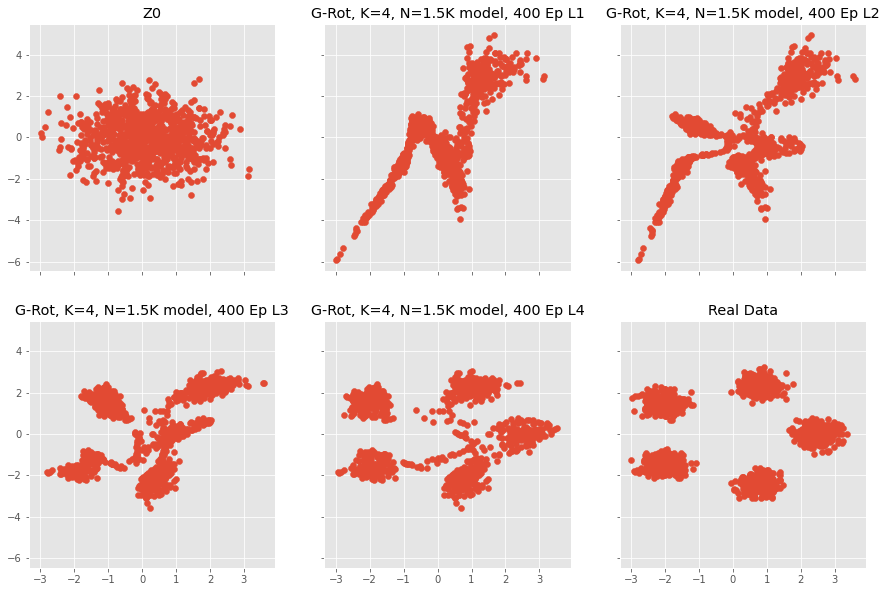

100%|███████████████████████████████████████████████████████████████████████████| 200/200 [01:02<00:00,  3.20 x axis/s]


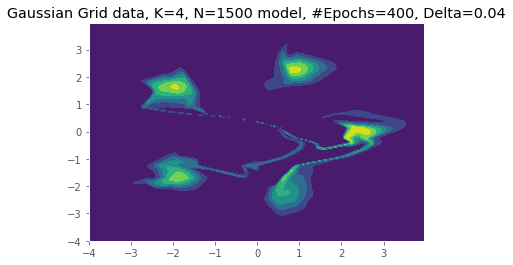

-I- Integral over density: 0.9998877325369835


In [48]:
plot_layers_output(model=gen_model_15, real_data=data_gauss_rot_1500.data, num_samples=1000, 
                   prefix="G-Rot, K=4, N=1.5K model, 400 Ep")
rx, ry, z = plot_model_prob_density(gen_model=gen_model_15, title="Gaussian Grid data, K=4, N=1500 model, #Epochs=400", 
                                    x_start=-4, x_final=4, y_start=-4, y_final=4)

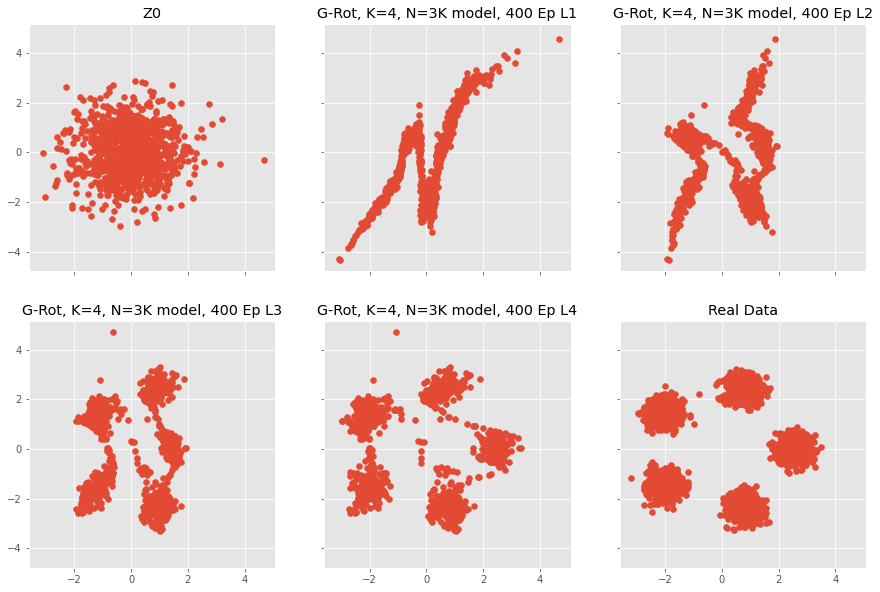

100%|███████████████████████████████████████████████████████████████████████████| 200/200 [00:58<00:00,  3.40 x axis/s]


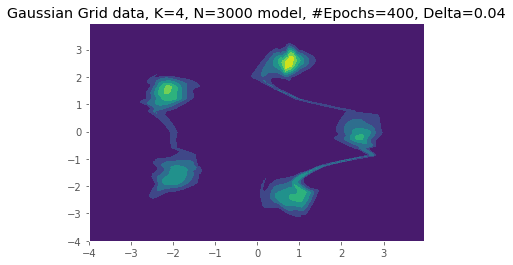

-I- Integral over density: 0.9992170771996844


In [49]:
plot_layers_output(model=gen_model_30, real_data=data_gauss_rot_3000.data, num_samples=1000, 
                   prefix="G-Rot, K=4, N=3K model, 400 Ep")
rx, ry, z = plot_model_prob_density(gen_model=gen_model_30, title="Gaussian Grid data, K=4, N=3000 model, #Epochs=400", 
                                    x_start=-4, x_final=4, y_start=-4, y_final=4)

## $\color{#007FFF}{\textbf{Discussion:}}$
As we can see the number of samples didn't change the basic structure of the probability function, but only the intensity of the values in the middle of the inner gaussians.

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 12</span>**. Train two flow models with $K=4$ layers for 250 epochs, using $N=1500$ samples from the `'GaussiansRot'` dataset with a varying number of Gaussians `num_gaussians`$=\left\{3, 7\right\}$. Compare the resulting estimated density $p(\mathbf{x})$ (using a grid of $100 \times 100$ points) and the intermediate distributions of $N=1000$ samples throughout the coupling layers of the model. Which distribution $p(\mathbf{x})$ is fitted better by the model? What do you conclude regarding the effect of data complexity? explain the result in your report and attach the resulting plots.

In [50]:
data_gauss_rot_g3 = ToyDataset('GaussiansRot', num_samples=1500, num_gaussians=3)
data_gauss_rot_g7 = ToyDataset('GaussiansRot', num_samples=1500, num_gaussians=7)

In [51]:
gen_model_g3, train_loss_g3, valid_loss_g3 = learn_coupling_flow(data_set=data_gauss_rot_g3, K=4, epochs=250)
gen_model_g7, train_loss_g7, valid_loss_g7 = learn_coupling_flow(data_set=data_gauss_rot_g7, K=4, epochs=250)

100%|████████████████████████████████| 250/250 [00:44<00:00,  5.56 Epoch/s, train_loss=1.6169928, valid_loss=1.6917473]



 Best Model achieved 1.6312 validation loss at epoch 243 



100%|████████████████████████████████| 250/250 [00:44<00:00,  5.59 Epoch/s, train_loss=2.6487215, valid_loss=2.6665554]


 Best Model achieved 2.6497 validation loss at epoch 248 



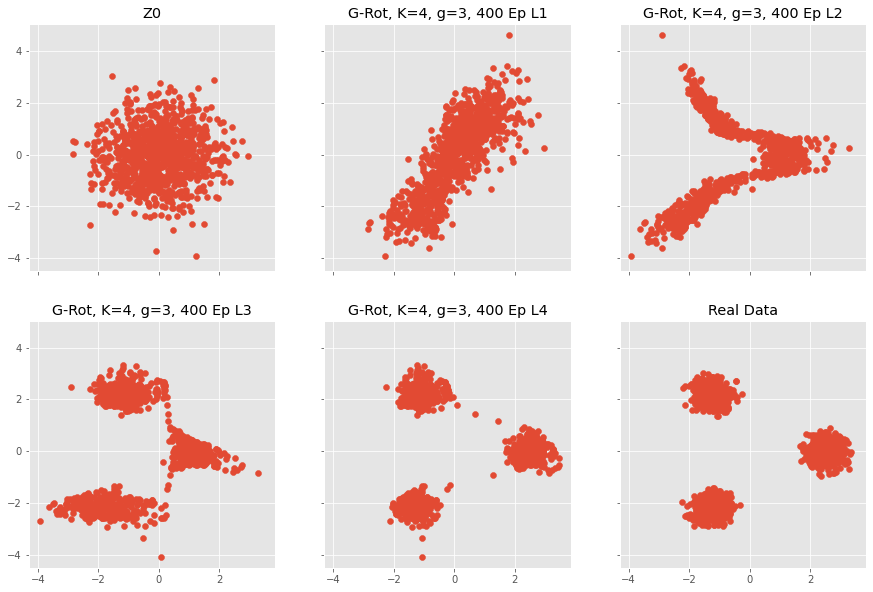

100%|███████████████████████████████████████████████████████████████████████████| 200/200 [01:03<00:00,  3.16 x axis/s]


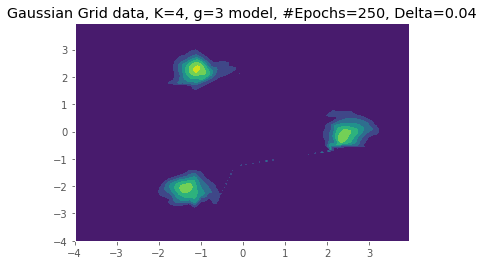

-I- Integral over density: 1.0001221049132392


In [52]:
plot_layers_output(model=gen_model_g3, real_data=data_gauss_rot_g3.data, num_samples=1000, 
                   prefix="G-Rot, K=4, g=3, 400 Ep")
rx, ry, z = plot_model_prob_density(gen_model=gen_model_g3, title="Gaussian Grid data, K=4, g=3 model, #Epochs=250", 
                                    x_start=-4, x_final=4, y_start=-4, y_final=4)

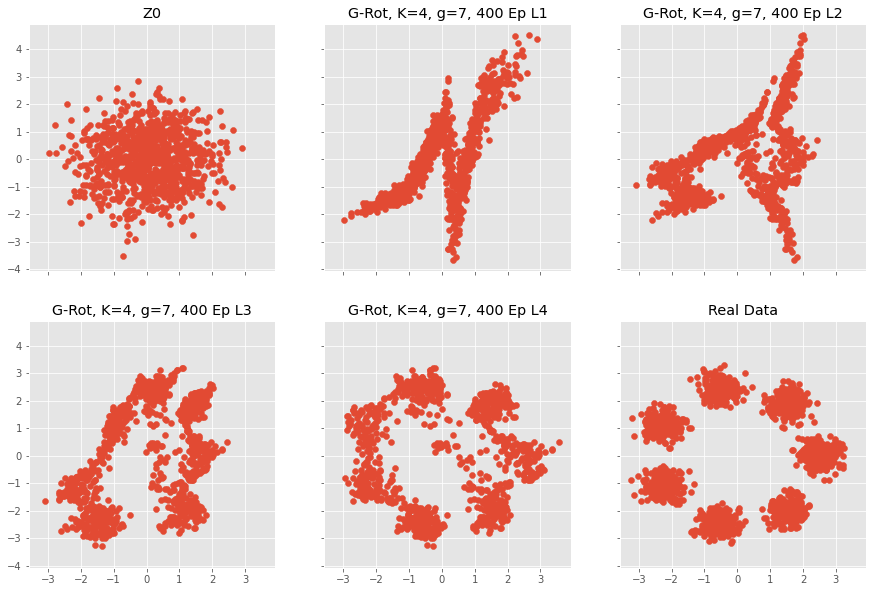

100%|███████████████████████████████████████████████████████████████████████████| 200/200 [01:05<00:00,  3.07 x axis/s]


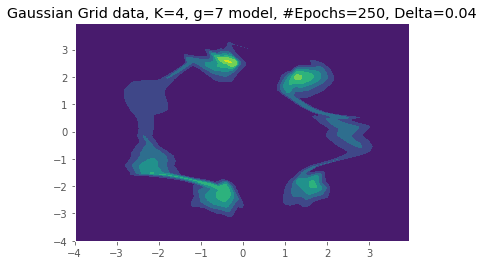

-I- Integral over density: 0.9999874679321722


In [53]:
plot_layers_output(model=gen_model_g7, real_data=data_gauss_rot_g7.data, num_samples=1000, 
                   prefix="G-Rot, K=4, g=7, 400 Ep")
rx, ry, z = plot_model_prob_density(gen_model=gen_model_g7, title="Gaussian Grid data, K=4, g=7 model, #Epochs=250", 
                                    x_start=-4, x_final=4, y_start=-4, y_final=4)

## $\color{#007FFF}{\textbf{Discussion:}}$
The data with the 3 gaussians was learned pretty good compare to the data with 7 gaussians. As can be seen some gaussian lost some volume and their mass was drifted to the other gaussians. This tells us that with data that is more complex and sensitive to noise we need more complex model or higher number of epochs or higher number of samples.

### Conclusion

In conclusion, we have seen how to implement our own normalizing flow on toy 2D datasets. However, as mentioned in the beginning of Part II, similar models with significantly more layers and additional tricks can be used to model images (e.g. [Glow](http://papers.nips.cc/paper/8224-glow-generative-flow-with-invertible-1x1-convolutions.pdf)). The most common flow element, the coupling layer, is simple to implement, and yet effective. Normalizing flows are an interesting generative model compared to GANs, as they allow an exact likelihood estimate in continuous space, and we have the guarantee that every possible input $x$ has a corresponding latent vector $z$. Recent advances in [Neural ODEs](https://arxiv.org/pdf/1806.07366.pdf) allow a flow with infinite number of layers, called Continuous Normalizing Flows, whose potential is yet to fully explore.

# TODO:
read all instructions and discuss results for each section
make sure everything done

change meshgrid to always be 10K points 100x100 ?

## References and Credits

[1] Dinh, L., Sohl-Dickstein, J., and Bengio, S. (2017). “Density estimation using Real NVP,” In: 5th International Conference on Learning Representations, ICLR 2017. [Link](https://arxiv.org/abs/1605.08803)

[2] Kingma, D. P., and Dhariwal, P. (2018). “Glow: Generative Flow with Invertible 1x1 Convolutions,” In: Advances in Neural Information Processing Systems, vol. 31, pp. 10215--10224. [Link](http://papers.nips.cc/paper/8224-glow-generative-flow-with-invertible-1x1-convolutions.pdf)

[3] University of Amsterdam, Deep Learning 1, Tutorial 11. [Link](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial11/NF_image_modeling.html#Normalizing-Flows-as-generative-model)

[4] Technical University of Munich, Machine Learning for Graphs and Sequential Data, Generative Models. [Link](https://www.in.tum.de/en/daml/teaching/summer-term-2020/machine-learning-for-graphs-and-sequential-data/)